# Collaborative Denoising Auto-Encoder (CDAE)

We present a new model-based collaborative filtering (CF) method for top-N recommendation called Collaborative Denoising Auto-Encoder (CDAE). CDAE assumes that whatever
user-item interactions are observed are a corrupted version of the user’s full preference set. The model learns latent representations
of corrupted user-item preferences that can best reconstruct the full
input.
In other words, during training, we feed the model a subset
of a user’s item set and train the model to recover the whole
item set; at prediction time, the model recommends new items to
the user given the existing preference set as input. Training on corrupted
data effectively recovers co-preference patterns. We show
that this is an effective approach for collaborative filtering.

# Acquire Data from Kaggle

In [0]:
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
import sys
import os.path
import tensorflow as tf
import time
import numpy as np
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

In [4]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 235kB 5.2MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyabansal25","key":"4e6e23c44e5d70e6aa448bcdde326c03"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets list

ref                                                      title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
xvivancos/transactions-from-a-bakery                     Transactions from a bakery                         113KB  2018-09-05 23:42:32           1845  
olistbr/brazilian-ecommerce                              Brazilian E-Commerce Public Dataset by Olist        25MB  2018-10-09 01:52:17           1030  
lava18/google-play-store-apps                            Google Play Store Apps                               2MB  2018-09-18 20:49:49          10266  
jacobbaruch/nba-player-of-the-week                       NBA player of the week                              16KB  2018-08-18 20:41:30            827  
census/census-bureau-usa                                 United States Census           

In [8]:
!kaggle competitions download -c kkbox-music-recommendation-challenge

  0% 0.00/453k [00:00<?, ?B/s]
100% 453k/453k [00:00<00:00, 82.5MB/s]
  0% 0.00/1.29M [00:00<?, ?B/s]
100% 1.29M/1.29M [00:00<00:00, 158MB/s]
 91% 38.0M/41.9M [00:00<00:00, 40.0MB/s]
100% 41.9M/41.9M [00:00<00:00, 90.9MB/s]
 90% 91.0M/101M [00:00<00:00, 69.0MB/s]
100% 101M/101M [00:00<00:00, 109MB/s]  
 96% 97.0M/101M [00:01<00:00, 72.0MB/s]
100% 101M/101M [00:01<00:00, 93.9MB/s] 
 95% 94.0M/98.8M [00:01<00:00, 39.9MB/s]
100% 98.8M/98.8M [00:01<00:00, 60.3MB/s]


In [9]:
#unzip training data file
!7z e train.csv.7z



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 106420688 bytes (102 MiB)

Extracting archive: train.csv.7z
--
Path = train.csv.7z
Type = 7z
Physical Size = 106420688
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      1% - train.csv                  4% - train.csv                  6% - train.csv                  8% - train.csv                 10% - train.csv                 12% - train.csv                 14% - train.csv                 17% - train.csv                 19% - train.csv

In [0]:
df = pd.read_csv('train.csv', sep=',', error_bad_lines=False, encoding="latin-1", nrows=10000)

In [4]:
df.shape

(10000, 6)

In [5]:
df = df.drop('source_screen_name', axis=1).drop('source_type', axis=1).drop('source_system_tab', axis=1)
df.shape

(10000, 3)

In [6]:
#index users
users = df.msno.unique()
usersdf = pd.DataFrame(users)
usersdf.head()

,0
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=
2,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=
3,TJU0Gfvy7FB+r89bWovPKXTjuApTCiv3xg/tt5shR78=
4,3g0bC24RD7QUeALY1IF/e8L6X3fHG298ZFIsCEG9T9Y=


In [7]:
usersdf['user_id'] = usersdf.index +1
usersdf.columns = ["msno","user_id"]
usersdf.head()


,msno,user_id
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2
2,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,3
3,TJU0Gfvy7FB+r89bWovPKXTjuApTCiv3xg/tt5shR78=,4
4,3g0bC24RD7QUeALY1IF/e8L6X3fHG298ZFIsCEG9T9Y=,5


In [8]:
#index songs
songs = df.song_id.unique()
songsdf = pd.DataFrame(songs)
songsdf['songid'] = songsdf.index +1
songsdf.columns = ["song_id","songid"]
songsdf.head()

,song_id,songid
0,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1
1,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,2
2,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,3
3,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,4
4,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,5


In [9]:
df = pd.merge(df, usersdf, on='msno')
df = pd.merge(df, songsdf, on='song_id')
df.head()

,msno,song_id,target,user_id,songid
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1,1,1
1,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,1,1,5
2,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,1,1,6
3,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,1,1,8
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,XUz4Z4wPPChz+OIwkwj7HJ8teIjW3rEMdEATM80rDxM=,1,1,326


In [10]:
df = df.drop("msno", axis=1).drop("song_id", axis=1)
df.head()

,target,user_id,songid
0,1,1,1
1,1,1,5
2,1,1,6
3,1,1,8
4,1,1,326


In [11]:
df = df[['user_id', 'songid', 'target']]
df.head()

,user_id,songid,target
0,1,1,1
1,1,5,1
2,1,6,1
3,1,8,1
4,1,326,1


In [12]:
df.shape

(10000, 3)

# Model


Similar to the standard Denoising Auto-Encoder, CDAE is also
represented as a one-hidden-layer neural network. The key difference
is that the input also encodes a latent vector for the user, which
allows CDAE to be a much better recommender model. Figure  shows a sample structure of CDAE. CDAE
consists of 3 layers, including the input layer, the hidden layer and
the output layer

![alt text](https://github.com/shreyabansal25/Recommended-Systems/blob/master/CDAE.PNG?raw=true)

In [0]:
# efficient version
def precision_recall_ndcg_at_k(k, rankedlist, test_matrix):
    idcg_k = 0
    dcg_k = 0
    n_k = k if len(test_matrix) > k else len(test_matrix)
    for i in range(n_k):
        idcg_k += 1 / math.log(i + 2, 2)

    b1 = rankedlist
    b2 = test_matrix
    s2 = set(b2)
    hits = [(idx, val) for idx, val in enumerate(b1) if val in s2]
    count = len(hits)

    for c in range(count):
        dcg_k += 1 / math.log(hits[c][0] + 2, 2)

    return float(count / k), float(count / len(test_matrix)), float(dcg_k / idcg_k)


def map_mrr_ndcg(rankedlist, test_matrix):
    ap = 0
    map = 0
    dcg = 0
    idcg = 0
    mrr = 0
    for i in range(len(test_matrix)):
        idcg += 1 / math.log(i + 2, 2)

    b1 = rankedlist
    b2 = test_matrix
    s2 = set(b2)
    hits = [(idx, val) for idx, val in enumerate(b1) if val in s2]
    count = len(hits)

    for c in range(count):
        ap += (c + 1) / (hits[c][0] + 1)
        dcg += 1 / math.log(hits[c][0] + 2, 2)

    if count != 0:
        mrr = 1 / (hits[0][0] + 1)

    if count != 0:
        map = ap / count

    return map, mrr, float(dcg / idcg)


def evaluate(self):
    
    pred_ratings_10 = {}
    pred_ratings_5 = {}
    pred_ratings = {}
    ranked_list = {}
    p_at_5 = []
    p_at_10 = []
    r_at_5 = []
    r_at_10 = []
    map = []
    mrr = []
    ndcg = []
    ndcg_at_5 = []
    ndcg_at_10 = []
    for u in self.test_users:
        user_ids = []
        user_neg_items = self.neg_items[u]
        item_ids = []
        # scores = []
        for j in user_neg_items:
            item_ids.append(j)
            user_ids.append(u)

        scores = self.predict(user_ids, item_ids)
        # print(type(scores))
        # print(scores)
        # print(np.shape(scores))
        # print(ratings)
        neg_item_index = list(zip(item_ids, scores))

        ranked_list[u] = sorted(neg_item_index, key=lambda tup: tup[1], reverse=True)
        pred_ratings[u] = [r[0] for r in ranked_list[u]]
        pred_ratings_5[u] = pred_ratings[u][:5]
        pred_ratings_10[u] = pred_ratings[u][:10]

        p_5, r_5, ndcg_5 = precision_recall_ndcg_at_k(5, pred_ratings_5[u], self.test_data[u])
        p_at_5.append(p_5)
        r_at_5.append(r_5)
        ndcg_at_5.append(ndcg_5)
        p_10, r_10, ndcg_10 = precision_recall_ndcg_at_k(10, pred_ratings_10[u], self.test_data[u])
        p_at_10.append(p_10)
        r_at_10.append(r_10)
        ndcg_at_10.append(ndcg_10)
        map_u, mrr_u, ndcg_u = map_mrr_ndcg(pred_ratings[u], self.test_data[u])
        map.append(map_u)
        mrr.append(mrr_u)
        ndcg.append(ndcg_u)

    print("-----------------------------------------------------")
    #print("precision@10: " + str(np.mean(p_at_10)))
    #print("recall@10: " + str(np.mean(r_at_10)))
    #print("precision@5: " + str(np.mean(p_at_5)))
    #print("recall@5: " + str(np.mean(r_at_5)))
    #print("map: " + str(np.mean(map)))
    #print("mrr: " + str(np.mean(mrr)))
    #print("ndcg: " + str(np.mean(ndcg)))
    #print("ndcg@5: " + str(np.mean(ndcg_at_5)))
    #print("ndcg@10: " + str(np.mean(ndcg_at_10)))
    
    return np.mean(p_at_5), np.mean(r_at_5)

In [0]:
class ICDAE():
    '''
    Based on CDAE and I-AutoRec, I designed the following item based CDAE, it seems to perform better than CDAE slightly.
    '''

    def __init__(self, sess, num_user, num_item, learning_rate=1e-3, reg_rate=0.1, epoch=25, batch_size=1000,
                 verbose=False, T=1, display_step=10):
        self.learning_rate = learning_rate
        self.epochs = epoch
        self.batch_size = batch_size
        self.reg_rate = reg_rate
        self.sess = sess
        self.num_user = num_user
        self.num_item = num_item
        self.verbose = verbose
        self.T = T
        self.display_step = display_step
        print("Item based CDAE.")

    def build_network(self, hidden_neuron=500, corruption_level=0):
        self.corrupted_interact_matrix = tf.placeholder(dtype=tf.float32, shape=[None, self.num_user])
        self.interact_matrix = tf.placeholder(dtype=tf.float32, shape=[None, self.num_user])
        self.item_id = tf.placeholder(dtype=tf.int32, shape=[None])
        self.corruption_level = corruption_level

        W = tf.Variable(tf.random_normal([self.num_user, hidden_neuron], stddev=0.01))
        W_prime = tf.Variable(tf.random_normal([hidden_neuron, self.num_user], stddev=0.01))
        V = tf.Variable(tf.random_normal([self.num_item, hidden_neuron], stddev=0.01))

        b = tf.Variable(tf.random_normal([hidden_neuron], stddev=0.01))
        b_prime = tf.Variable(tf.random_normal([self.num_user], stddev=0.01))
        # print(np.shape(tf.matmul(self.corrupted_interact_matrix, W)))
        # print(np.shape( tf.nn.embedding_lookup(V, self.item_id)))
        layer_1 = tf.sigmoid(tf.matmul(self.corrupted_interact_matrix, W) + b)
        self.layer_2 = tf.sigmoid(tf.matmul(layer_1, W_prime) + b_prime)

        self.loss = - tf.reduce_sum(
            self.interact_matrix * tf.log(self.layer_2) + (1 - self.interact_matrix) * tf.log(1 - self.layer_2)) \
                    + self.reg_rate * (
        tf.nn.l2_loss(W) + tf.nn.l2_loss(W_prime) + tf.nn.l2_loss(b) + tf.nn.l2_loss(b_prime))

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)

    def prepare_data(self, train_data, test_data):
        self.train_data = self._data_process(train_data).transpose()
        self.neg_items = self._get_neg_items(train_data)
        self.num_training = self.num_item
        self.total_batch = int(self.num_training / self.batch_size)
        self.test_data = test_data
        self.test_users = set([u for u in self.test_data.keys() if len(self.test_data[u]) > 0])
        print("data preparation finished.")

    def train(self):

        idxs = np.random.permutation(self.num_training)  # shuffled ordering

        for i in range(self.total_batch):
            start_time = time.time()
            if i == self.total_batch - 1:
                batch_set_idx = idxs[i * self.batch_size:]
            elif i < self.total_batch - 1:
                batch_set_idx = idxs[i * self.batch_size: (i + 1) * self.batch_size]

            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict={
                self.corrupted_interact_matrix: self._get_corrupted_input(self.train_data[batch_set_idx, :],
                                                                          self.corruption_level),
                self.interact_matrix: self.train_data[batch_set_idx, :],
                self.item_id: batch_set_idx
                })
            if self.verbose and i % self.display_step == 0:
                print("Index: %04d; cost= %.9f" % (i + 1, np.mean(loss)))
                if self.verbose:
                    print("one iteration: %s seconds." % (time.time() - start_time))

    def test(self):
        self.reconstruction = self.sess.run(self.layer_2, feed_dict={self.corrupted_interact_matrix: self.train_data,
                                                                     self.item_id: range(self.num_item)}).transpose()
        
        precision, recall = evaluate(self)
        return precision, recall, self.reconstruction

    def execute(self, train_data, test_data):
        self.prepare_data(train_data, test_data)
        init = tf.global_variables_initializer()
        self.sess.run(init)
        precision =[]
        recall =[]
        error =[]
        for epoch in range(self.epochs):
            self.train()
            if (epoch) % self.T == 0:
                prec, rec , err= self.test()
                print("Epoch: %04d; " % (epoch), end='')
                precision.append(prec)
                recall.append(rec)
                error.append(np.mean(err))
        return precision, recall, error

    def save(self, path):
        saver = tf.train.Saver()
        saver.save(self.sess, path)

    def predict(self, user_id, item_id):
        return np.array(self.reconstruction[np.array(user_id), np.array(item_id)])

    def _data_process(self, data):
        return np.asmatrix(data)

    def _get_neg_items(self, data):
        neg_items = {}
        for u in range(self.num_user):
            neg_items[u] = [k for k, i in enumerate(data[u]) if data[u][k] == 0]
            # print(neg_items[u])

        return neg_items

    def _get_corrupted_input(self, input, corruption_level):
        return np.random.binomial(n=1, p=1 - corruption_level) * input


In [0]:
def load_data_all(test_size=0.2, sep="\t"):
  
    n_users = df.user_id.unique().shape[0]
    n_items = df.songid.unique().shape[0]
    
    print("Number of users:", n_users, "Number of items:", n_items)
    train_data, test_data = train_test_split(df, test_size=test_size)
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    
    
    train_row = []
    train_col = []
    train_rating = []

    train_dict = {}
    for line in train_data.itertuples():
        u = line[1] - 1
        i = line[2] - 1
        train_dict[(u, i)] = 1
    print("train_dict done")
    
    for u in range(n_users):
        for i in range(n_items):
            train_row.append(u)
            train_col.append(i)
            if (u, i) in train_dict.keys():
                train_rating.append(1)
            else:
                train_rating.append(0)
    train_matrix = csr_matrix((train_rating, (train_row, train_col)), shape=(n_users, n_items))
    all_items = set(np.arange(n_items))
    print("train_matrix done")
    
    neg_items = {}
    train_interaction_matrix = []
    for u in range(n_users):
        neg_items[u] = list(all_items - set(train_matrix.getrow(u).nonzero()[1]))
        train_interaction_matrix.append(list(train_matrix.getrow(u).toarray()[0]))

    test_row = []
    test_col = []
    test_rating = []
    for line in test_data.itertuples():
        test_row.append(line[1] - 1)
        test_col.append(line[2] - 1)
        test_rating.append(1)
    test_matrix = csr_matrix((test_rating, (test_row, test_col)), shape=(n_users, n_items))
    print("test_matrix done")
    
    test_dict = {}
    for u in range(n_users):
        test_dict[u] = test_matrix.getrow(u).nonzero()[1]

  

    return train_interaction_matrix, test_dict, n_users, n_items



In [20]:
import matplotlib.pyplot as plt

model ='CDAE'
epochs = 25
num_factors = 10
display_step = 10
batch_size = 100  # 128 for unlimpair
learning_rate = 1e-3  # 1e-4 for unlimpair
reg_rate = 0.1  # 0.01 for unlimpair
train_data, test_data, n_user, n_item = load_data_all(test_size=0.2, sep="\t")

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    model = ICDAE(sess, n_user, n_item)
    model.build_network()
    precision, recall, error = model.execute(train_data, test_data)
    
print('Done!!!')
    
    


Number of users: 1622 Number of items: 5772
train_dict done
train_matrix done
test_matrix done
Item based CDAE.
data preparation finished.
-----------------------------------------------------
Epoch: 0000; -----------------------------------------------------
Epoch: 0001; -----------------------------------------------------
Epoch: 0002; -----------------------------------------------------
Epoch: 0003; -----------------------------------------------------
Epoch: 0004; -----------------------------------------------------
Epoch: 0005; -----------------------------------------------------
Epoch: 0006; -----------------------------------------------------
Epoch: 0007; -----------------------------------------------------
Epoch: 0008; -----------------------------------------------------
Epoch: 0009; -----------------------------------------------------
Epoch: 0010; -----------------------------------------------------
Epoch: 0011; -----------------------------------------------------
Epo

**Precision**

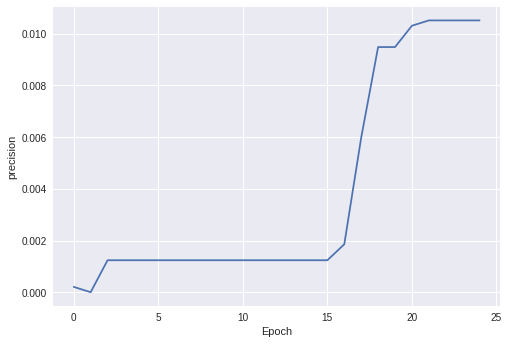

In [21]:
plt.plot(precision)
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.show()
    

**Error**

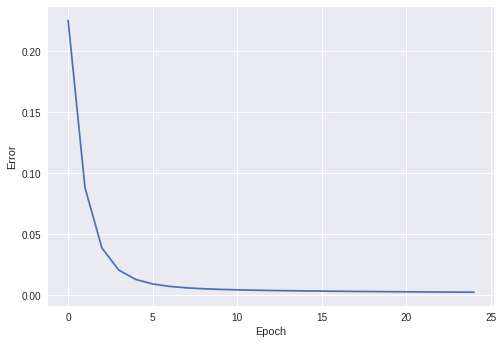

In [22]:
plt.plot(error)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()